## Self supervised large scale generalisatiom

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised/train.json"

#s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-8437-8437-1529-bert-2022-10-23-05-08-24-286/2022102311/"
#s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-8217-767-1593-bert--2022-10-16-20-14-51-295/2022101719/"
#s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-7665-7665-1390-bert-2022-10-23-05-08-26-498/2022102320/"
s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-1150-1150-208-bert--2022-10-24-03-31-14-781/2022102921/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised-fake/base/train.json"



In [3]:
is_download_files= True

In [4]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 8.04 s, sys: 6.7 s, total: 14.7 s
Wall time: 33.6 s


In [9]:
!ls -l $local_temp_pred_dir | wc -l

      24


In [10]:
default_threshold =  0.99
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}


In [11]:
threshold_config

{'False': {'confidence': 0.99}, 'True': {'confidence': 0.99}}

In [12]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [13]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)

        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
            # sample = min(1000, len(df_sub) )
            sample = min(1000, len(df_sub) )
            # high_quality_frames_per_interaction.append(df_sub.sample(n=sample))
            high_quality_frames_per_interaction.append(df_sub)


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            sample=min(1000, len(df_low) )
            #low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
            low_quality_frames_per_interaction.append(df_low)
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [14]:


def is_in_training_pubmed(df, training_df):
    return df["abstract_id"].isin(training_df["abstract_id"])

In [15]:
download_file(s3_training, local_temp_wk_dir)
training_data_file = os.path.join(local_temp_wk_dir, s3_training.split("/")[-1])
data_training_full_df = pd.read_json(training_data_file)

In [16]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)
df_high_quality_threshold[ "RecordInTrainingData"] = is_in_training_pubmed( df_high_quality_threshold, data_training_full_df)
df_summary["RecordInTrainingData"] = is_in_training_pubmed( df_summary, data_training_full_df)
df_low_quality_threshold[ "RecordInTrainingData"]= is_in_training_pubmed( df_low_quality_threshold, data_training_full_df)

CPU times: user 6.42 s, sys: 410 ms, total: 6.83 s
Wall time: 6.99 s


In [17]:
df_summary.dtypes

prediction               object
confidence              float64
confidence_std          float64
abstract_id               int64
RecordInTrainingData       bool
dtype: object

In [18]:
df_summary.groupby("prediction")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
prediction,,,,,,,,
False,436114.0,0.987311,0.053891,0.500157,0.998959,0.999541,0.999644,0.999780
True,64705.0,0.938449,0.116219,0.500027,0.950784,0.995224,0.998197,0.999047


In [19]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [20]:
df_high_quality_threshold.shape, df_summary.shape

((430378, 9), (500819, 5))

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


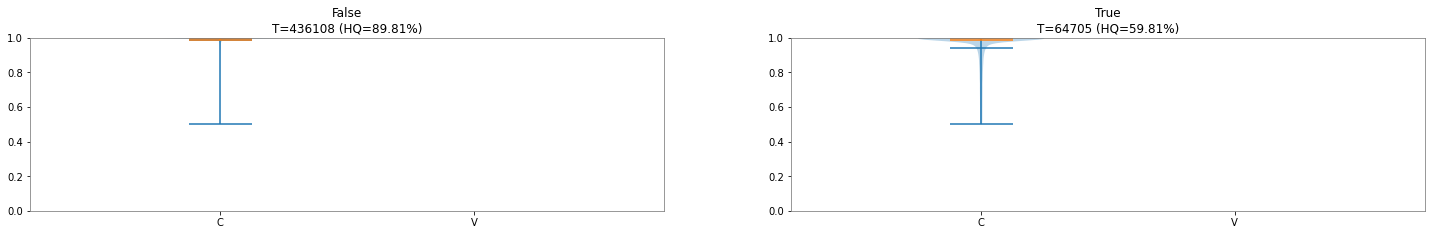

In [21]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [22]:
df_summary["confidence"].describe()

count    500819.000000
mean          0.980998
std           0.067399
min           0.500027
25%           0.997943
50%           0.999478
75%           0.999636
max           0.999780
Name: confidence, dtype: float64

In [23]:
df_low_quality_threshold["prediction"].value_counts()

False    9650
True     7970
Name: prediction, dtype: int64

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


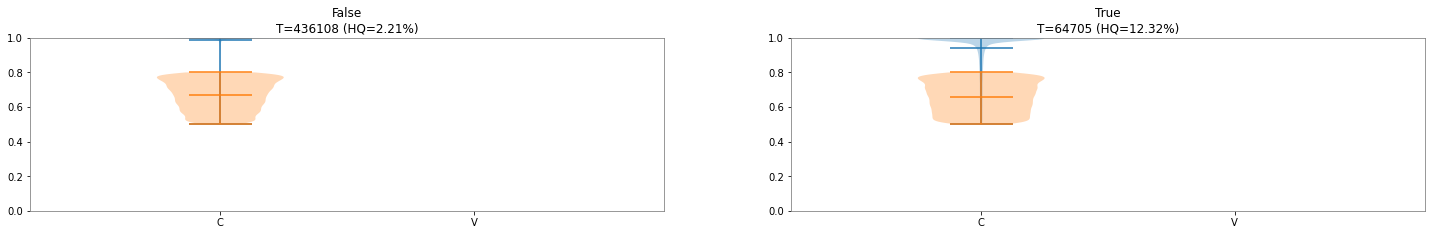

In [24]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [25]:
df_summary.shape

(500819, 5)

In [26]:
df_summary[["confidence","prediction"]].groupby("prediction").describe().T

prediction                False          True
confidence count  436114.000000  64705.000000
           mean        0.987311      0.938449
           std         0.053891      0.116219
           min         0.500157      0.500027
           25%         0.998959      0.950784
           50%         0.999541      0.995224
           75%         0.999644      0.998197
           max         0.999780      0.999047

In [27]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()


        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    
    
    
    dfs = [summary_df,  thresh_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  thresh\_count \\
prediction &            &               \\
\midrule
False      &     436108 &        391677 \\
True       &      64705 &         38697 \\
Total      &     500813 &        430374 \\
\bottomrule
\end{tabular}

CPU times: user 178 ms, sys: 21.5 ms, total: 200 ms
Wall time: 165 ms


,all_count,thresh_count
prediction,,
False,436108,391677
True,64705,38697
Total,500813,430374


In [28]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
False    391681
True      38697
dtype: int64

In [29]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [30]:

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")

df_high_quality_threshold.to_json(local_file_high_q_sample,  orient='records')
df_low_quality_threshold.to_json(local_file_low_q_sample,   orient='records')




In [31]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [32]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd
import tempfile
import transformers

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = ref_file_or_df
    marker_target_file = target_file_or_df

    
    if isinstance(ref_file_or_df, str):
        df_ref_marker = pd.read_json(marker_ref_file)
        df_target_marker =  pd.read_json(marker_target_file)
    else:
        df_ref_marker = marker_ref_file
        df_target_marker = marker_target_file
        
    t = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=None, stop_words=None, analyzer=lambda x: t.convert_ids_to_tokens(t([x], add_special_tokens=False)["input_ids"][0])[:512])
    comparison_result = comparer(df_ref_marker["abstract"].tolist(), df_target_marker["abstract"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [33]:
df_high_quality_threshold.shape

(430378, 9)

In [34]:
df_sim_score_high = get_sim_scores(data_training_full_df, df_high_quality_threshold, n_gram=1, additional_target_cols=list(df_high_quality_threshold.columns))

df_sim_score_high.head()


Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


,abstract_id,abstract,false,true,prediction,confidence,confidence_std,raw_confidence,RecordInTrainingData,sim_score
0,18506356,Psoriasis represents a potentially life-alteri...,0.999655,0.000345,False,0.999655,NaN,[0.999655127525329],False,0.652574
1,18506357,The pemphigus variants represent a group of po...,0.999560,0.000440,False,0.999560,NaN,[0.9995598196983331],False,0.619396
2,18506359,Renin is the rate limiting enzyme in the renin...,0.996470,0.003530,False,0.996470,NaN,[0.99647045135498],False,0.566603
4,18506360,"Neuromedin-U (NMU) is a brain-gut peptide, whi...",0.999393,0.000608,False,0.999393,NaN,[0.9993925094604491],False,0.535136
5,18506362,Although a number of environmental risk factor...,0.995758,0.004242,False,0.995758,NaN,[0.9957576394081111],False,0.553220


<AxesSubplot:>

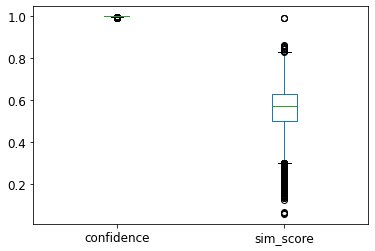

In [35]:
df_sim_score_high[["confidence","sim_score"]].plot.box()

Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

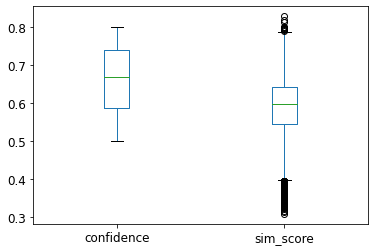

In [36]:
df_sim_score_low = get_sim_scores(data_training_full_df, df_low_quality_threshold, n_gram=1, additional_target_cols=list(df_low_quality_threshold.columns))
df_sim_score_low[["confidence","sim_score"]].plot.box()

In [37]:
def plot_box_sim_scores_confidence(df_high, df_low):
    p_unique = sorted(list(df_high["prediction"].unique()))
    
    _, axes = plt.subplots(1, len(p_unique), figsize=(30 ,8))
    
    for i, l in enumerate(p_unique):
        dh = df_high.query(f"prediction == '{l}'")
        dl = df_low.query(f"prediction == '{l}'")
        
        dl = dl[["confidence", "sim_score"]]
        dh = dh[["confidence", "sim_score"]]                   
                    
        
        data = dh.values.T.tolist()
        data.extend(dl.values.T.tolist())
      
        ax=axes[i]
        ax.boxplot(data, showmeans=True)
        ax.set_title(l)
        ax.set_xticklabels(["GHC","GHS", "GLC", "GLS"])


In [38]:
df_sim_score_high["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    430378.000000
mean        128.858968
std          80.364071
min           1.000000
25%          54.000000
50%         127.000000
75%         192.000000
max        1560.000000
Name: abstract, dtype: float64

In [39]:
df_sim_score_low["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    17620.000000
mean       176.104484
std         84.826825
min         21.000000
25%        108.000000
50%        173.000000
75%        233.000000
max       1514.000000
Name: abstract, dtype: float64

In [40]:
data_training_full_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    767.000000
mean     233.923077
std       69.000061
min       46.000000
25%      189.500000
50%      236.000000
75%      266.000000
max      730.000000
Name: abstract, dtype: float64

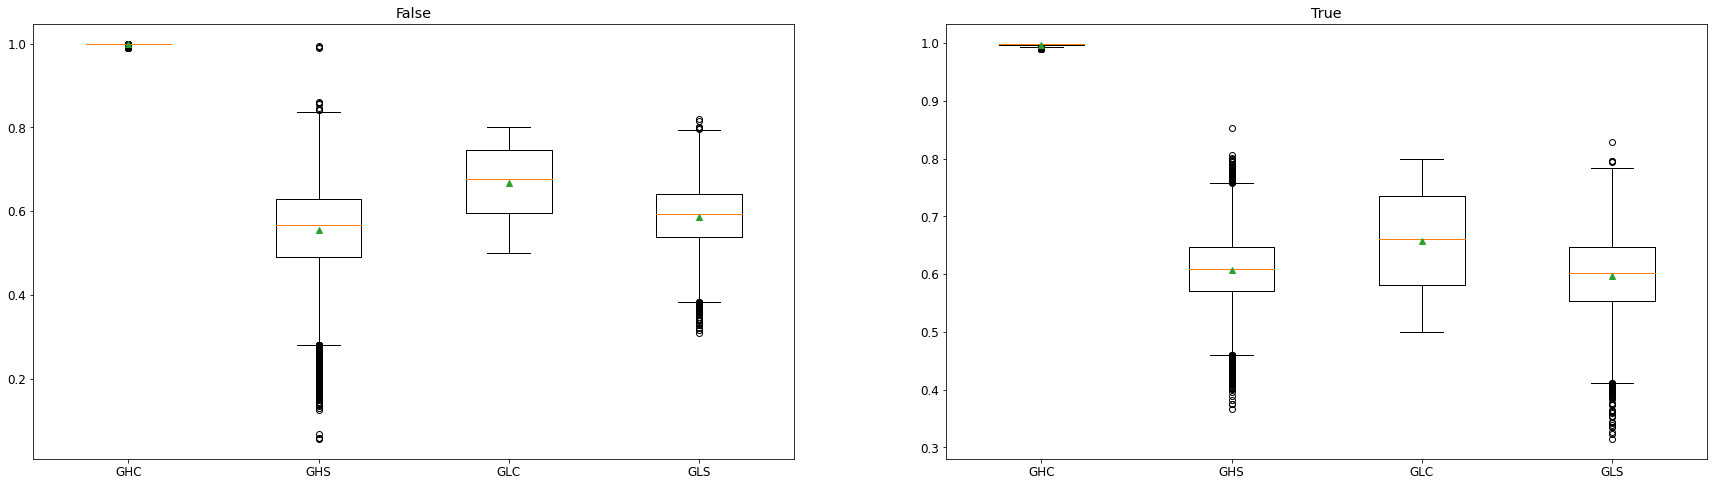

In [41]:
plot_box_sim_scores_confidence(df_sim_score_high, df_sim_score_low)

In [42]:
df_sim_score_high[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False        391681.0  0.999093  0.001376  0.990004  0.999309  0.999572   
True          38697.0  0.997086  0.002052  0.990001  0.996434  0.997982   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.999650  0.999780  391681.0  0.554246  0.100766  0.055956   
True        0.998495  0.999047   38697.0  0.607947  0.055315  0.365894   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.489593  0.567084  0.628313  0.993318  
True        0.571501  0.609567  0.646187  0.852665

In [43]:
df_sim_score_low[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False          9650.0  0.667753  0.086679  0.500157  0.596064  0.676151   
True           7970.0  0.657526  0.087763  0.500027  0.581966  0.661610   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.745219  0.799971    9650.0  0.586245  0.075814  0.308759   
True        0.734970  0.799994    7970.0  0.597224  0.070298  0.314494   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.537831  0.592584  0.640672  0.818892  
True        0.552735  0.601800  0.646463  0.829408

In [44]:
df_sim_score_high.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'Expression of the Pho regulon in Escherichia coli is induced in response to low levels of environmental phosphate (P(i)). Under these conditions, the high-affinity PstSCAB(2) protein (i.e., with two PstB proteins) is the primary P(i) transporter. Expression from the pstSCAB-phoU operon is regulated by the PhoB/PhoR two-component regulatory system. PhoU is a negative regulator of the Pho regulon; however, the mechanism by which PhoU accomplishes this is currently unknown. Genetic studies of phoU have proven to be difficult because deletion of the phoU gene leads to a severe growth defect and creates strong selection for compensatory mutations resulting in confounding data. To overcome the instability of phoU deletions, we employed a promoter-swapping technique that places expression of the phoBR two-component system under control of the P(tac) promoter and the lacO(ID) regulatory module. This technique may be generally applicable for controlling expression of other chromosomal genes in

In [45]:
df_sim_score_low.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'Blood flow is controlled by an integrated network of resistance arteries that are coupled in series and parallel with one another. To dramatically alter tissue perfusion as required during periods of high metabolic demand, arterial networks must dilate in a coordinated manner. Gap junctions facilitate arterial coordination by enabling electrical stimuli to conduct among endothelial and (or) smooth muscle cells. The goal of this review was to provide an introduction to the field of vascular communication, the process of intercellular conduction, and the manner in which key properties influence charge flow. After a brief historical introduction, we establish the idea that electrical stimuli conduct differentially among neighbouring endothelial and smooth muscle cells. Highlighting recent studies that have synergistically combined computational and experimental approaches, this perspective explores how specific structural, electrical, and gap junctional properties enable electrical pheno

## Label analysis

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

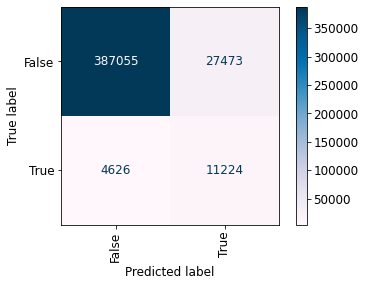

In [47]:
plot_confusionmatrix(df_high_quality_threshold.pipe(self_label)["self_label"], 
                     df_high_quality_threshold["prediction"]) 

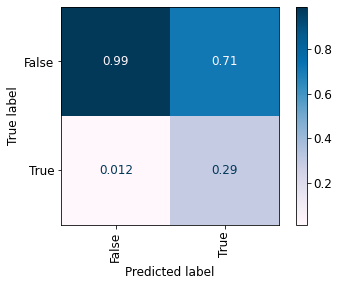

In [48]:
plot_confusionmatrix(df_high_quality_threshold.pipe(self_label)["self_label"], 
                     df_high_quality_threshold["prediction"],
                    normalize="pred") 

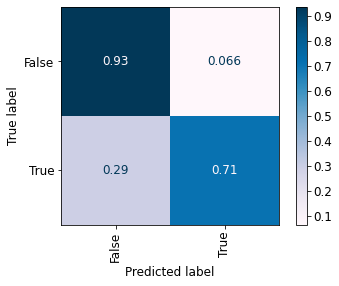

In [49]:
plot_confusionmatrix(df_high_quality_threshold.pipe(self_label)["self_label"], 
                     df_high_quality_threshold["prediction"],
                    normalize="true") 

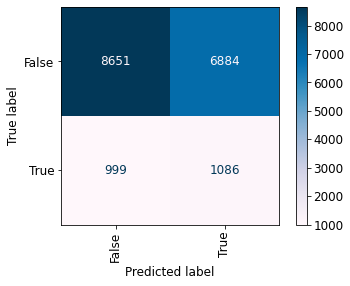

In [50]:
plot_confusionmatrix(df_low_quality_threshold.pipe(self_label)["self_label"], 
                     df_low_quality_threshold["prediction"])